# Invoice factoring

In [242]:
import datetime, os, itertools
import pandas as pd
import tensorflow as tf
import tensorflow.feature_column as fc
from sklearn.model_selection import train_test_split
%matplotlib inline
import matplotlib.pyplot as plt
tf.get_logger().setLevel('ERROR')

In [234]:
df = pd.read_csv('invoice_data.csv', index_col = 0)

FEATURES = ['countryCode', 'customerID', 'InvoiceAmount',
       'Disputed', 'PaperlessBill','repeatCust','Late', 'DaysToSettle',
       'countlate']

LABEL = 'DaysLate'


train, test_val = train_test_split(df, random_state = 0)
test, val = train_test_split( test_val, random_state = 0)

feature_cols = [tf.feature_column.numeric_column(k) for k in features]

In [235]:
estimator = tf.estimator.LinearRegressor(    
        feature_columns=feature_cols,   
        model_dir="train")

In [236]:
def get_input_fn(data_set, num_epochs=None, n_batch = 128, shuffle=True):
    return tf.compat.v1.estimator.inputs.pandas_input_fn(       
         x=pd.DataFrame({k: data_set[k].values for k in FEATURES}),       
         y = pd.Series(data_set[LABEL].values),       
         batch_size=n_batch,          
         num_epochs=num_epochs,       
         shuffle=shuffle)

In [237]:
estimator.train(input_fn=get_input_fn(train,                                       
                                           num_epochs=100,                                      
                                           n_batch = 128,                                      
                                           shuffle=True),                                      
                                           steps=1000)

In [238]:
ev = estimator.evaluate(    
          input_fn=get_input_fn(test,                          
          num_epochs=1,                          
          n_batch = 128,                          
          shuffle=False))

In [239]:
loss_score = ev["loss"]
print("Loss: {0:f}".format(loss_score))

Loss: 12.764492


In [244]:
y = estimator.predict(    
         input_fn=get_input_fn(val,                          
         num_epochs=1,                          
         n_batch = 128,                          
         shuffle=False))
pred = pd.DataFrame({'Measured': val[LABEL], 'Predicted': [p['predictions'][0] for p in y]})

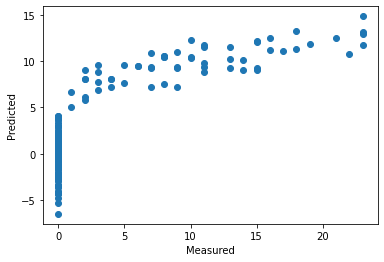

In [246]:
fig, ax = plt.subplots()
ax.scatter(pred.Measured, pred.Predicted)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()